<h1 style="font-size: 200%;color: darkgreen; font-weight: bold; text-align:center">Numerical Simulation Laboratory 2021</h1>

<p style="text-align:center"><b>Author:</b> Giacomo Riccardo Hvaring</p>

---

# 12. Image recognition with Neural Networks

The goal of exercise 12 is to use deep neural network models, implemented in the Keras python package, to recognize and distinguish between the ten handwritten digits (0-9).

The MNIST dataset comprises $70000$ handwritten digits, each of which comes in a square image, divided into a $28\times 28$ pixel grid. Every pixel can take on $256$ gradation of the gray color, interpolating between white and black, and hence each data point assumes any value in the set $\{0,1,\dots,255\}$. Since there are $10$ categories in the problem, corresponding to the ten digits, this problem represents a generic **classification task**. 

In [1]:
from libsim import *                        # module containing some handy functions for the labs

results_directory += "lab_12/"              # where to look for the data
HTML(custom_css())   

In [2]:
import tensorflow as tf
from tensorflow import keras
import os

seed = 0
np.random.seed(seed) # fix random seed
tf.random.set_seed(seed)

## data loading and processing

Keras can conveniently download the MNIST data from the web. All we need to do is import the `mnist` module and use the `load_data()` class, and it will create the training and test data sets for us.

The MNIST set has pre-defined test and training sets, in order to facilitate the comparison of the performance of different models on the data.

Once we have loaded the data, we need to format it into the correct shape.

In [3]:
from keras.datasets import mnist

# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
# output
num_classes = 10 # 10 digits

# split the data between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28)
Y_train shape: (60000,)

60000 train samples
10000 test samples


an example of a data point with label 4 (image below)
an example of a data point with label 4 before to_categorical ...
... and with label [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] after to_categorical

X_train shape: (60000, 784)
Y_train shape: (60000, 10)


/Users/giacomo/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


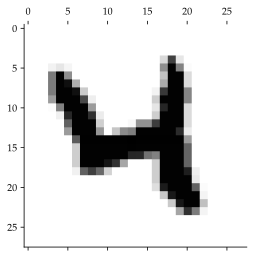

In [4]:
# reshape data, it could depend on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)

# cast floats to single precesion
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# rescale data in interval [0,1]
X_train /= 255
X_test /= 255

# look at an example of data point
print('an example of a data point with label', Y_train[20], '(image below)')
# matshow: display a matrix in a new figure window

plt.matshow(X_train[20,:].reshape(28,28),cmap='binary')

print('an example of a data point with label', Y_train[20], 'before to_categorical ...')
# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)
print('... and with label', Y_train[20], 'after to_categorical')
print()
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

In [5]:
def load_and_reshape_data():
    # load
    (X_train, Y_train), (X_test, Y_test) = mnist.load_data()
    
    # reshape
    X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
    X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)

    # cast floats to single precesion
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    # rescale data to [0,1]
    X_train /= 255
    X_test /= 255

    # convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
    Y_train = keras.utils.to_categorical(Y_train, num_classes)
    Y_test = keras.utils.to_categorical(Y_test, num_classes)
    
    return X_train, Y_train, X_test, Y_test

**Example:** to_categorical

In [6]:
# Consider an array of 5 labels out of a set of 3 classes {0, 1, 2}:
labels = np.array([0, 2, 1, 2, 0])
# `to_categorical` converts this into a matrix with as many columns as there are classes.
# The number of rows stays the same.
keras.utils.to_categorical(labels)

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

## Neural Network architecture

We can now move on to construct our deep neural net. We shall use Keras's `Sequential()` class to instantiate a model, and will add different deep layers one by one using the `add()` method

For the purposes of our example, it suffices to focus on `Dense` layers for simplicity. Every `Dense()` layer accepts as its first required argument an integer which specifies the number of neurons. The type of activation function for the layer is defined using the `activation` optional argument, the input of which is the name of the activation function in `string` format. Examples include `relu`, `tanh`, `elu`, `sigmoid`, `softmax`. 

In order for our DNN to work properly, we have to make sure that the numbers of input and output neurons for each layer match. Therefore, we specify the shape of the input in the first layer of the model explicitly using the optional argument `input_shape=(N_features,)`. The sequential construction of the model then allows Keras to infer the correct input/output dimensions of all hidden layers automatically. Hence, we only need to specify the size of the softmax output layer to match the number of categories.

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

def create_DNN():
    # instantiate model
    model = Sequential()
    # add a dense all-to-all relu layer
    model.add(Dense(400,input_shape=(img_rows*img_cols,), activation='relu'))
    # add a dense all-to-all relu layer
    model.add(Dense(100, activation='relu'))
    # apply dropout with rate 0.5
    model.add(Dropout(0.5))
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

print('Model architecture created successfully!')

Model architecture created successfully!


## optimizer and cost function

Next, we choose the loss function according to which to train the DNN. For classification problems, this is the cross entropy, and since the output data was cast in categorical form, we choose the `categorical_crossentropy` defined in Keras' `losses` module. Depending on the problem of interest one can pick any other suitable loss function. To optimize the weights of the net, we choose SGD. This algorithm is already available to use under Keras' `optimizers` module, but we could use any other built-in one as well. The parameters for the optimizer, such as `lr` (learning rate) or `momentum` are passed using the corresponding optional arguments of the `SGD()` function. All available arguments can be found in Keras' online documentation at [https://keras.io/](https://keras.io/). While the loss function and the optimizer are essential for the training procedure, to test the performance of the model one may want to look at a particular `metric` of performance. For instance, in categorical tasks one typically looks at their `accuracy`, which is defined as the percentage of correctly classified data points. To complete the definition of our model, we use the `compile()` method, with optional arguments for the `optimizer`, `loss`, and the validation `metric` as follows:

In [8]:
#from keras.optimizers import Adam, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
# the optimizer import does not work for some reason

def compile_model():
    # create the model
    model=create_DNN()
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='sgd',
                  metrics=['accuracy'])
    return model

print('Model compiled successfully and ready to be trained.')

Model compiled successfully and ready to be trained.


## model training

We train our DNN in minibatches. 

Shuffling the training data during training improves stability of the model. Thus, we train over a number of training epochs. Each epoch corresponds to using **all the train data** divided in minibatches.

Training the DNN is a one-liner using the `fit()` method of the `Sequential` class. The first two required arguments are the training input and output data. As optional arguments, we specify the mini-`batch_size`, the number of training `epochs`, and the test or `validation_data`. To monitor the training procedure for every epoch, we set `verbose=True`. 

In [9]:
# training parameters
batch_size = 32
epochs = 5

# create the deep neural net
model_DNN = compile_model()

# train DNN and store training info in history
history = model_DNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

Epoch 1/5
1875/1875 [==============================] - 14s 2ms/step - loss: 1.1197 - accuracy: 0.6616 - val_loss: 0.3028 - val_accuracy: 0.9176
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3886 - accuracy: 0.8892 - val_loss: 0.2340 - val_accuracy: 0.9324
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3176 - accuracy: 0.9101 - val_loss: 0.1969 - val_accuracy: 0.9421
Epoch 4/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2690 - accuracy: 0.9257 - val_loss: 0.1722 - val_accuracy: 0.9479
Epoch 5/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2320 - accuracy: 0.9346 - val_loss: 0.1572 - val_accuracy: 0.9501


##  model performance evaluation with *unseen* test data

Next, we evaluate the model and read of the loss on the test data, and its accuracy using the `evaluate()` method.

313/313 [==============================] - 0s 950us/step - loss: 0.1572 - accuracy: 0.9501

Test loss: 0.15718883275985718
Test accuracy: 0.9501000046730042


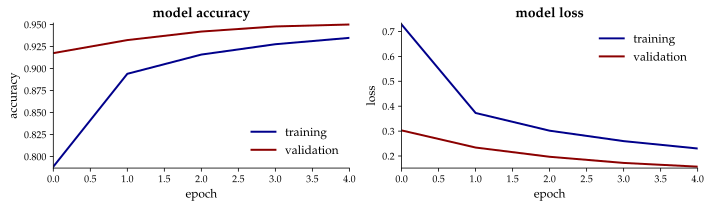

In [10]:
# evaluate model
score = model_DNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].plot(history.history['accuracy'], label='training')
ax[0].plot(history.history['val_accuracy'], label='validation')
set_labels(ax[0], 'model accuracy', 'epoch', 'accuracy')
ax[0].legend()

# summarize history for loss
ax[1].plot(history.history['loss'], label='training')
ax[1].plot(history.history['val_loss'], label='validation')
set_labels(ax[1], 'model loss', 'epoch', 'loss')
ax[1].legend();

Dropout, during training, slices off some artificial neurons, thus, training accuracy suffers.

Dropout, during testing, turns itself off and allows all of the ‘weak classifiers’ in the neural network to be used. Thus, testing accuracy improves with respect to training accuracy.

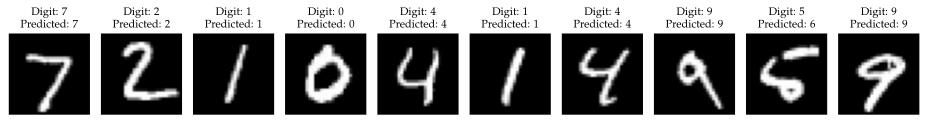

In [11]:
#X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
predictions = model_DNN.predict(X_test)

x_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(13, 10)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(x_test[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted:    {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])), size=11)    
    plt.axis('off')
plt.show()

## exercise 12.1

By keeping fixed all the other parameters, try to use at least **two other optimizers**, different from SGD. 

<p class='remark'>Watch to accuracy and loss for training and validation data and comment on the performances.</p>

In [12]:
def compile_model_opt(optimizer):
    # create the model
    model=create_DNN()
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [13]:
# Adam, RMSprop, Adagrad, Adadelta, Adamax, Nadam

def plot_accuracy_and_loss(ax, history, optimizer, color, labels=['training','validation']):
    # accuracy
    ax[0].plot(history.history['accuracy'], c=color, label=labels[0] + ' ('+ optimizer + ')')
    ax[0].plot(history.history['val_accuracy'], c=color, ls='--', alpha=0.5, label=labels[1] + ' ('+ optimizer + ')')
    set_labels(ax[0], 'model accuracy', 'epoch', 'accuracy')
    ax[0].legend()
    # loss
    ax[1].plot(history.history['loss'], c=color, label=labels[0] + ' ('+ optimizer + ')')
    ax[1].plot(history.history['val_loss'], c=color, ls='--', alpha=0.5, label=labels[1] + ' ('+ optimizer + ')')
    set_labels(ax[1], 'model loss', 'epoch', 'loss')
    ax[1].legend();

def plot_optimizer(ax, optimizer, color):
    
    model_DNN = compile_model_opt(optimizer)
    
    # train DNN and store training info in history
    X_train, Y_train, X_test, Y_test = load_and_reshape_data()

    history = model_DNN.fit(X_train, Y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=0,
              validation_data=(X_test, Y_test))

    # evaluate model
    score = model_DNN.evaluate(X_test, Y_test, verbose=0)

    # print performance
    print()
    print('Optimizer:', optimizer.upper())
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    # look into training history

    # summarize history for accuracy
    plot_accuracy_and_loss(ax, history, optimizer, color)


Optimizer: ADAM
Test loss: 0.07080818712711334
Test accuracy: 0.9814000129699707

Optimizer: RMSPROP
Test loss: 0.1526397466659546
Test accuracy: 0.9733999967575073

Optimizer: ADAGRAD
Test loss: 0.3200254738330841
Test accuracy: 0.9150999784469604

Optimizer: ADADELTA
Test loss: 1.4892017841339111
Test accuracy: 0.7204999923706055

Optimizer: ADAMAX
Test loss: 0.0784868523478508
Test accuracy: 0.9746999740600586

Optimizer: NADAM
Test loss: 0.07480636984109879
Test accuracy: 0.9789000153541565


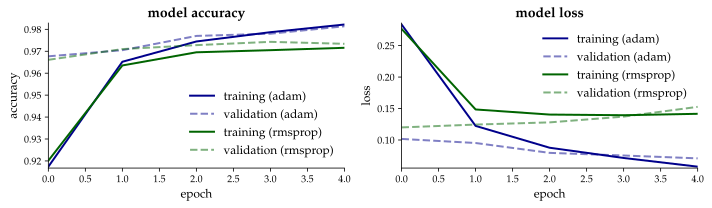

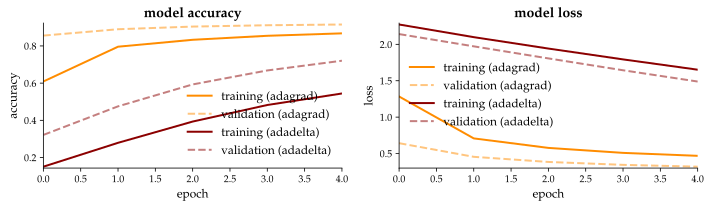

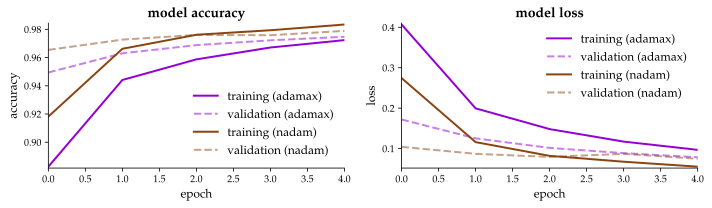

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
for optimizer, color in zip(['adam',  'rmsprop'], ['darkblue', 'darkgreen']):
    plot_optimizer(ax, optimizer, color)
    
fig, ax = plt.subplots(1, 2, figsize=(10,3))
for optimizer, color in zip(['adagrad',  'adadelta'], ['darkorange', 'darkred']):
    plot_optimizer(ax, optimizer, color)
    
fig, ax = plt.subplots(1, 2, figsize=(10,3))
for optimizer, color in zip(['adamax',  'nadam'], ['darkviolet', 'saddlebrown']):
    plot_optimizer(ax, optimizer, color)

For this NN, the best choices seem to be ADAM or NADAM, which hover around 98% accuracy after being trained for 5 epochs, with a loss of $\approx0.07$ on the validation data.

Close second is ADAMAX, with a 97.4% accuracy and 0.08 loss on the test data, similar to RMSPROP, which has a higher loss. ADAGRAD and ADADELTA do not particularly excel, with respectively a 91% and 69% accuracy.

Compared to SGD, which had a 95% accuracy and 0.15 loss on the test data, most of the alternatives perform better in this situation.

## convolutional Neural Networks with Keras

We have so far considered each MNIST data sample as a $(28\times 28)$-long 1d vector. On the other hand, we do know that in every one of the hand-written digits there are *local* spatial correlations between the pixels, but also *translational invariance*, which we would like to take advantage of to improve the accuracy of our classification model. To this end, we first need to reshape the training and test input data as follows

In [19]:
# you will need the following for Convolutional Neural Networks
from keras.layers import Flatten, Conv2D, MaxPooling2D

def convolutional_data():
    X_train, Y_train, X_test, Y_test = load_and_reshape_data()
    # reshape data, depending on Keras backend
    if keras.backend.image_data_format() == 'channels_first':
        X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
        X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
        input_shape = (1, img_rows, img_cols)
    else:
        X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
        X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)
        
    return X_train, X_test, input_shape
    
X_train, X_test, input_shape = convolutional_data()

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000, 10)

60000 train samples
10000 test samples


One can ask whether a neural net can learn to recognize such local patterns. This can be achieved by using convolutional layers.

## exercise 12.2

Change the architecture of your DNN using convolutional layers. Use `Conv2D`, `MaxPooling2D`, `Dropout`, but also do not forget `Flatten`, a standard `Dense` layer and `soft-max` in the end. I have merged step 2 and 3 in the following definition of `create_CNN()` that **you should complete**:

In [20]:
x = np.random.randint(0, 10, 28*28)

In [21]:
def create_CNN():
    # instantiate model
    model = Sequential()
    # add first convolutional layer with 10 filters (dimensionality of output space)
    model.add(Conv2D(10, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
    
    # MY LAYERS
    # second convolutional layer (with more filters, and smaller kernel for a finer categorization)
    model.add(Conv2D(20, kernel_size=(2, 2), activation='relu'))
    # pooling, to coarsen data
    model.add(MaxPooling2D(pool_size=(4, 4)))
    # flatten layer
    model.add(Flatten())
    # dense layer
    model.add(Dense(100, activation='relu'))
    # smaller dense layer
    model.add(Dense(20, activation='relu'))
    # dropout with rate 0.5
    model.add(Dropout(0.5))
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='SGD',
                  metrics=['accuracy'])
    return model

Train your DCNN and evaluate its performance proceeding exactly as before:

In [22]:
# training parameters
batch_size = 32
epochs = 5

# create the deep conv net
model_CNN=create_CNN()

# train CNN
model_CNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

# evaliate model
score = model_CNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/5
1875/1875 [==============================] - 14s 6ms/step - loss: 1.8752 - accuracy: 0.3263 - val_loss: 0.3805 - val_accuracy: 0.9018
Epoch 2/5
1875/1875 [==============================] - 12s 6ms/step - loss: 0.7673 - accuracy: 0.7277 - val_loss: 0.2103 - val_accuracy: 0.9415
Epoch 3/5
1875/1875 [==============================] - 13s 7ms/step - loss: 0.5643 - accuracy: 0.8028 - val_loss: 0.1302 - val_accuracy: 0.9646
Epoch 4/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.4513 - accuracy: 0.8455 - val_loss: 0.1020 - val_accuracy: 0.9721
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.0885 - accuracy: 0.9757

Test loss: 0.08854839950799942
Test accuracy: 0.9757000207901001


In the end, **add the evaluation of your CNN performances** like that used for the DNN.

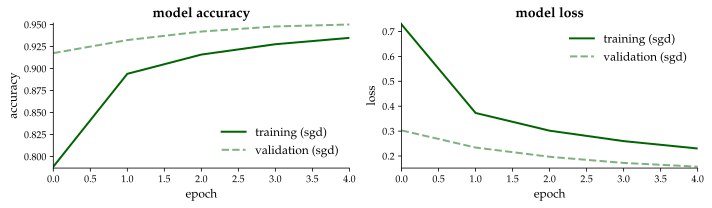

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
plot_accuracy_and_loss(ax, history, 'sgd', 'darkgreen')

## exercise 12.3

Use the `gimp` application to create 10 pictures of your "handwritten" digits, import them in your jupyter-notebook and try to see if your CNN is able to recognize your handwritten digits.

For example, you can use the following code to import a picture of an handwritten digit
(Note: you should install Python Image Library (PIL/Pillow):

In [24]:
from PIL import Image
import os

def predict_image(filename):
    digit_filename = './numbers/' + filename + '.png'
    digit_input = Image.open(digit_filename).convert('L')
    ydim, xdim = digit_input.size
    #print("Image size: " + str(xdim) + "x" + str(ydim))
    pixels = digit_input.load()
    data = np.zeros((xdim, ydim))
    for j in range(ydim):
        for i in range(xdim):
            data[i,j] = 1 - pixels[j,i] / 255
    data = data.reshape(1, xdim * ydim) # flatten for prediction
    prediction = model_DNN.predict(data)
    data = data.reshape(xdim, ydim) # back to square image
    
    # plot prediction vs. handwritten image
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].imshow(data, cmap='gray')   
    set_labels(ax[0], f'Digit predicted: {np.argmax(prediction)}')
    ax[0].axis(False) 
    ax[1].bar(np.arange(10), prediction[0], color='darkgrey', alpha=0.5)
    ax[1].xaxis.set_ticks(np.arange(10))
    ax[1].legend([f'${100 * np.max(prediction):.2f}\%$ sure']);

In [37]:
numbers = np.array(os.listdir('numbers'))

simple_mask = [ len(number) == 5 for number in numbers ]
different_mask = [ (len(number) > 5 and 'png' in number and not 'bad' in number) for number in numbers ]
bad_mask = [ (len(number) > 5 and 'png' in number and 'bad' in number) for number in numbers ]

simple_numbers = numbers[simple_mask]
different_numbers = numbers[different_mask]
bad_numbers = numbers[bad_mask]

simple_numbers.sort()
different_numbers.sort()
bad_numbers.sort()

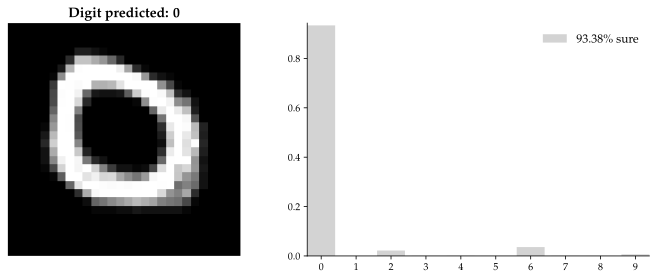

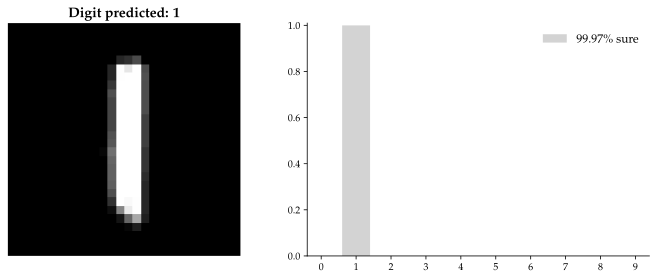

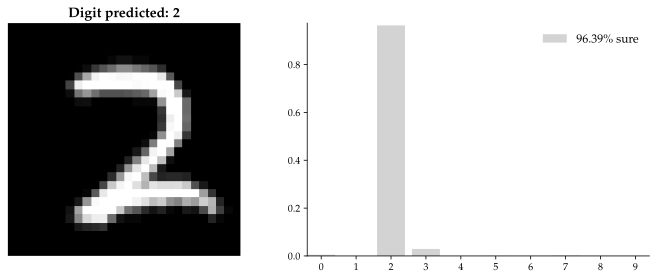

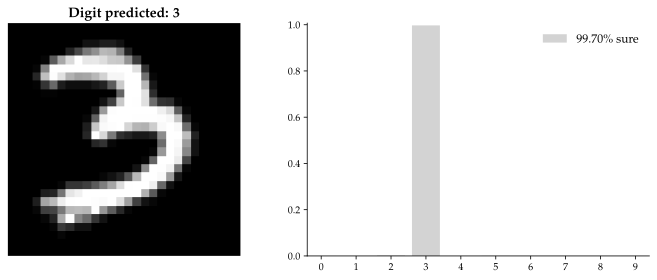

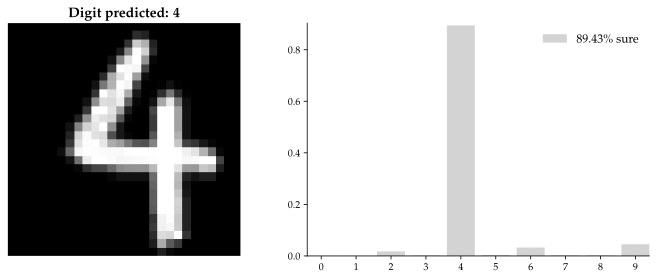

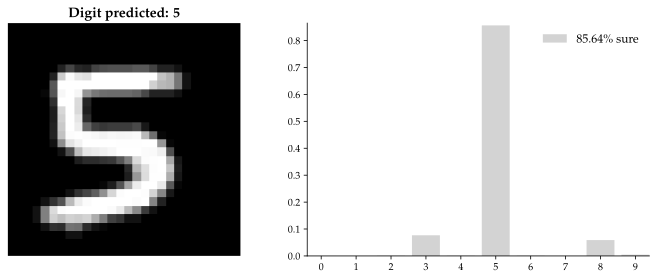

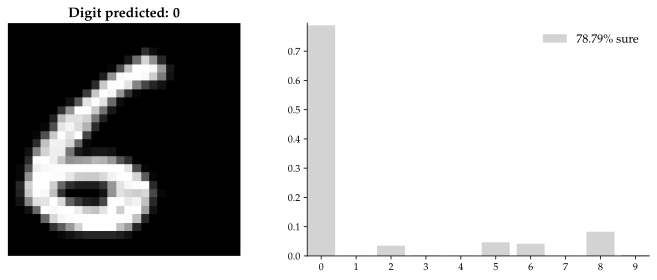

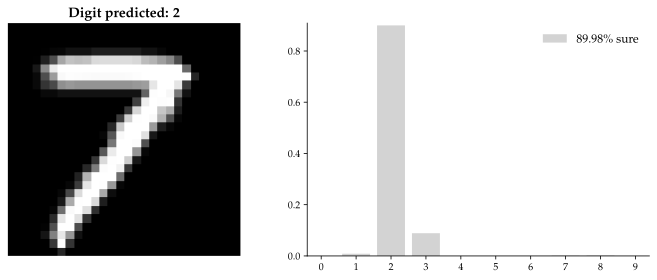

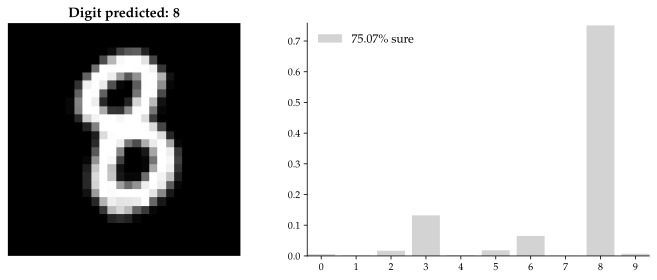

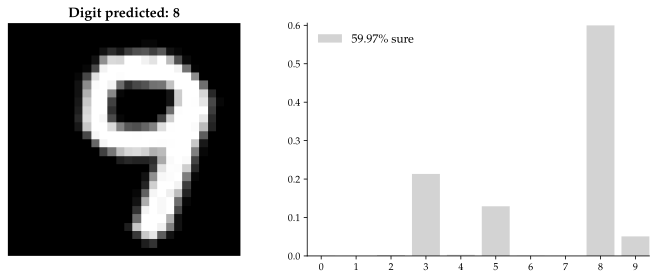

In [38]:
for number in simple_numbers:
    predict_image(number[:-4])

Cases where the NN failed in recognising digit purposefully written to be recognized:
- 6, guessed as 0
- 7, guessed as 2
- 9, guessed as 8

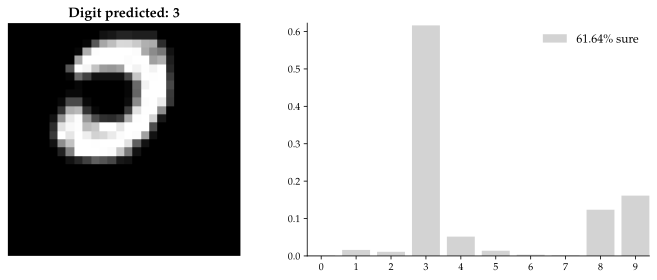

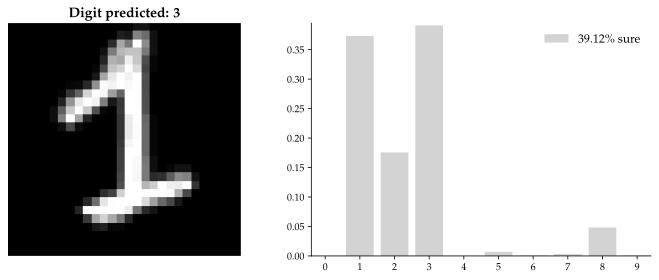

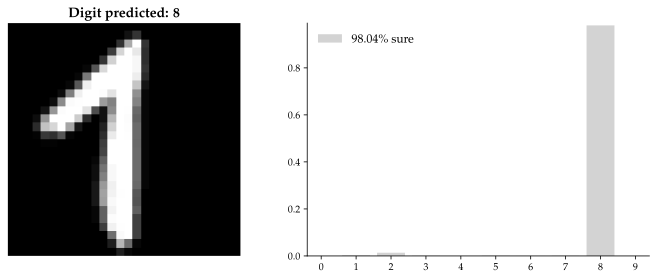

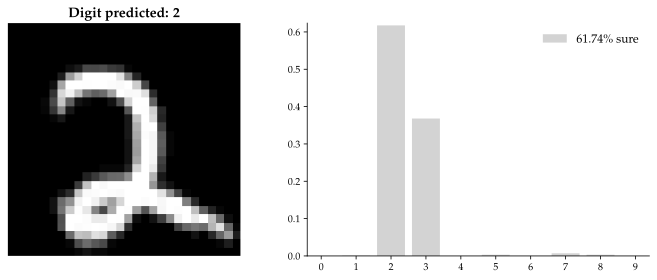

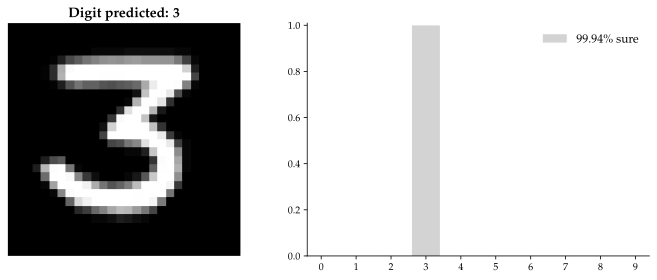

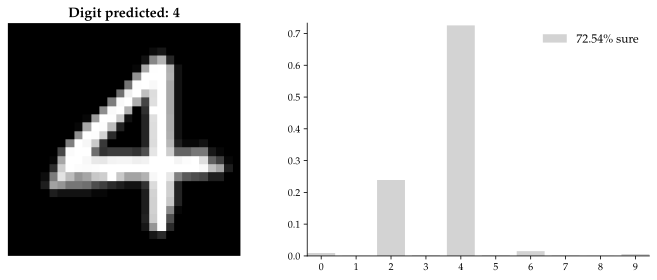

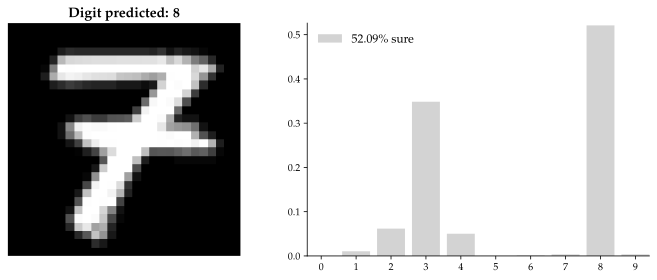

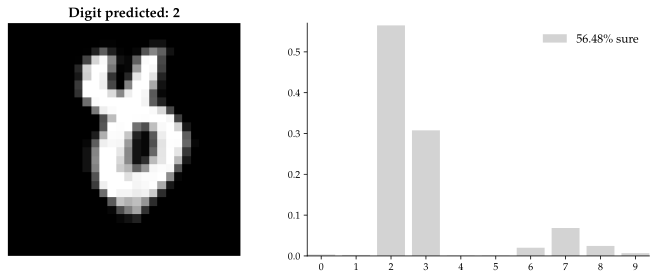

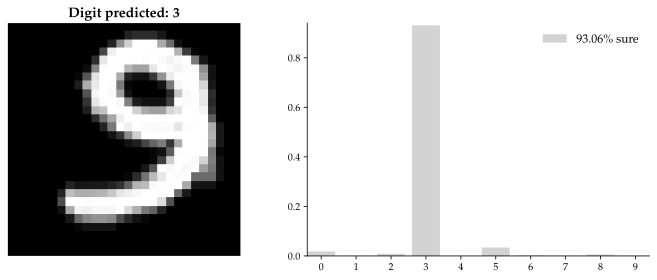

In [39]:
for number in different_numbers:
    predict_image(number[:-4])

Got lucky with 2 and 3, for the other it was a massacre. Let's see how it does with badly written digits!

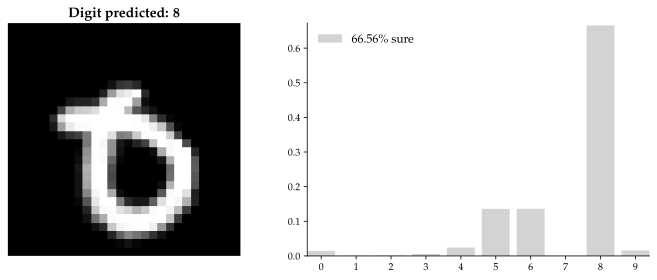

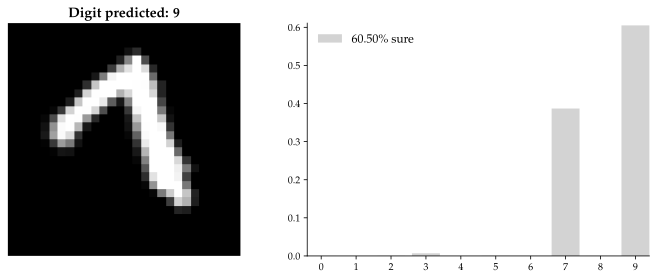

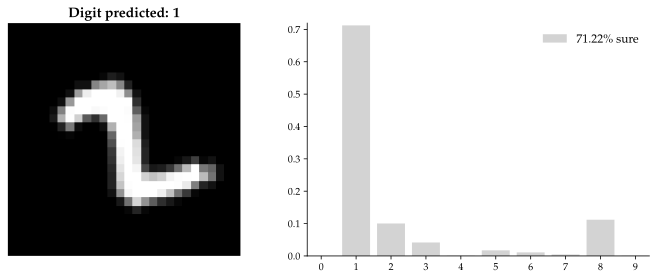

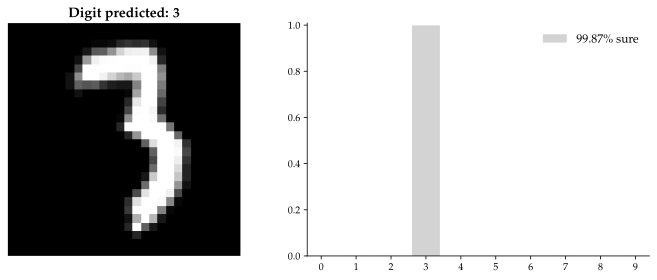

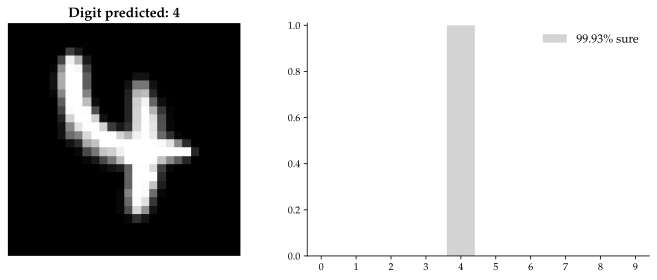

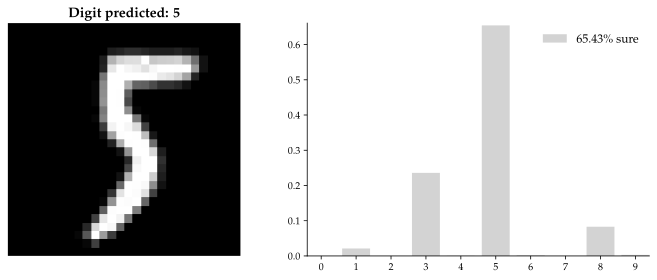

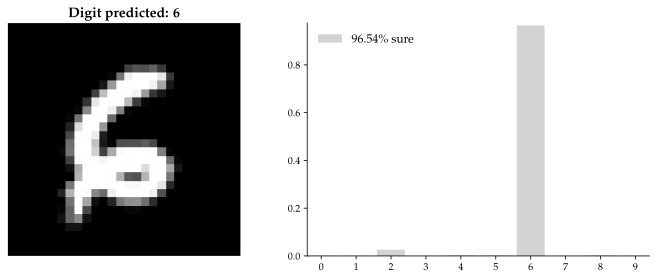

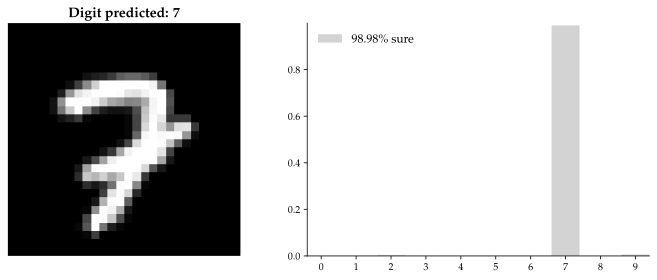

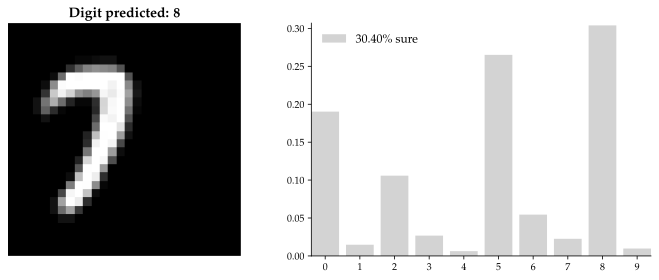

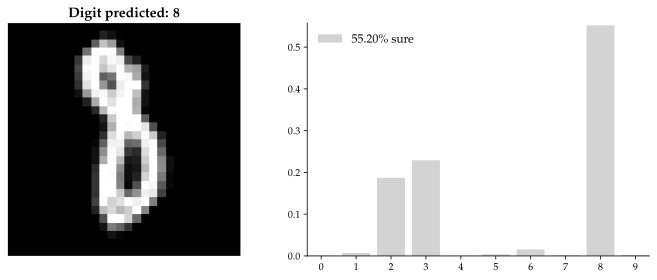

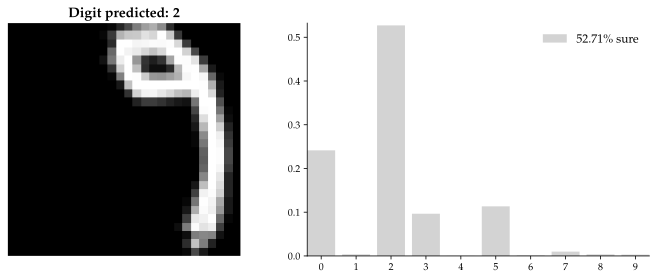

In [40]:
for number in bad_numbers:
    predict_image(number[:-4])

3, 4, 5 and 6 and 7 seem pretty solid, for the others (apart from 8 maybe) it has no idea of what it is looking at. Which is not bad at all, but still far from perfect.